### Quora Data Challenge

In [43]:
import io
import numpy as np
import pandas as pd
import pandasql as ps
import plotly.tools as tls
import plotly.offline as py
import pandas_profiling as pp
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Suppose you are a Data Scientist on the Mobile team at Quora.<br>The team has just introduced a new UI design to the Quora app.<br>The goal of the new design is to increase user engagement (measured by minutes spent on site). <br>The team ran an A/B test to evaluate the change.<br> Using the data, help the team understand the impact of the UI change better.

Tables provided are as follows:
    1. t1_user_active_min.csv
    2. t2_user_variant.csv
    3. t3_user_active_min_pre.csv
    4. t4_user_attributes.csv

In [153]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')

def build_dist(df,df1,col,col1,xlabelvalue):
    sns.distplot(df[col], hist=False, label = "before A/B Testing", axlabel = xlabelvalue)
    sns.distplot(df1[col1], hist=False, label = "after A/B Testing", axlabel = xlabelvalue)
    plt.show()

<Figure size 800x640 with 0 Axes>

In [44]:
# #function  for pie plot for customer attrition types
# def plot_pie(column) :
    
#     '''
#     This function plots the different pie graphs for categorical data
#     '''
    
#     trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
#                     labels  = churn[column].value_counts().keys().tolist(),
#                     hoverinfo = "label+percent+name",
#                     domain  = dict(x = [0,.48]),
#                     name    = "Churn Customers",
#                     marker  = dict(line = dict(width = 2,
#                                                color = "rgb(243,243,243)")
#                                   ),
#                     hole    = .6
#                    )
#     trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
#                     labels  = not_churn[column].value_counts().keys().tolist(),
#                     hoverinfo = "label+percent+name",
#                     marker  = dict(line = dict(width = 2,
#                                                color = "rgb(243,243,243)")
#                                   ),
#                     domain  = dict(x = [.52,1]),
#                     hole    = .6,
#                     name    = "Non churn customers" 
#                    )


#     layout = go.Layout(dict(title = column + " distribution in customer attrition ",
#                             plot_bgcolor  = "rgb(243,243,243)",
#                             paper_bgcolor = "rgb(243,243,243)",
#                             annotations = [dict(text = "churn customers",
#                                                 font = dict(size = 13),
#                                                 showarrow = False,
#                                                 x = .15, y = .5),
#                                            dict(text = "Non churn customers",
#                                                 font = dict(size = 13),
#                                                 showarrow = False,
#                                                 x = .88,y = .5
#                                                )
#                                           ]
#                            )
#                       )
#     data1 = [trace1,trace2]
#     fig  = go.Figure(data = data1,layout = layout)
#     py.iplot(fig)

# #for all categorical columns plot pie
# for i in cat_cols :
#     plot_pie(i)

In [45]:
# reading the data sets
t1_user_active_min     = pd.read_csv("t1_user_active_min.csv")
t2_user_variant        = pd.read_csv("t2_user_variant.csv")
t3_user_active_min_pre = pd.read_csv("t3_user_active_min_pre.csv")
t4_user_attributes     = pd.read_csv("t4_user_attributes.csv")
df_list = [t1_user_active_min,t2_user_variant,t3_user_active_min_pre,t4_user_attributes]

In [46]:
t1_user_active_min.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [47]:
t2_user_variant.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [48]:
t2_user_variant['variant_number'].value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

People in control group: 80 percent <br>
People in treatment group: 20 percent

In [49]:
user_control = []
user_treatment = []
for index,row in t2_user_variant.iterrows():
    if row['variant_number'] == 0:
        user_control.append(row['uid'])
    else:
        user_treatment.append(row['uid'])

In [50]:
t3_user_active_min_pre.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [51]:
t4_user_attributes.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


### Hypothesis:
1. The AB Testing is intended to increase the user engagement in terms of time.
2. Randomized people are used to divide into control and treatment groups.

### KPI for AB Test to look for between treatment and control group:
1. Active time        - increased/ decreased
2. Frequency of visit - increased/decreased
3. Segregation of above two points for old/new users, male/female, reader/non-readers.
4. I will try to look for the combination of all the other factors

#### Creating Analytical Data Table for the user variant - combination of gender/reader/non-reader/days_since_signup

In [52]:
var_gen_ageinquora = pd.merge(t2_user_variant,t4_user_attributes,how = "inner", on = "uid")

In [53]:
var_gen_ageinquora.head()

,uid,variant_number,dt,signup_date,gender,user_type
0,0,0,2019-02-06,2018-09-24,male,non_reader
1,1,0,2019-02-06,2016-11-07,male,reader
2,2,0,2019-02-06,2018-09-17,male,non_reader
3,3,0,2019-02-06,2018-03-04,male,non_reader
4,4,0,2019-02-06,2017-03-09,male,non_reader


In [54]:
var_gen_ageinquora_control = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 0]
var_gen_ageinquora_treatment = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 1]
cat_cols = ['gender','user_type']
cont_cols = ['days_since_joined_till_AB_tested']

#### Checking the ratio in treatment and control group

In [55]:
treat_gender = pd.DataFrame(var_gen_ageinquora_treatment['gender'].value_counts())
treat_gender.rename(columns = {'gender':'count_treat_gender'}, inplace = True)
treat_gender.reset_index(inplace = True)
treat_gender.rename(columns = {'index':'gender'}, inplace = True)

In [56]:
control_gender = pd.DataFrame(var_gen_ageinquora_control['gender'].value_counts())
control_gender.rename(columns = {'gender':'count_control_gender'}, inplace = True)
control_gender.reset_index(inplace = True)
control_gender.rename(columns = {'index':'gender'}, inplace = True)

In [57]:
total_gender = pd.DataFrame(var_gen_ageinquora['gender'].value_counts())
total_gender.rename(columns = {'gender':'count_control_gender'}, inplace = True)
total_gender.reset_index(inplace = True)
total_gender.rename(columns = {'index':'gender'}, inplace = True)

In [58]:
treat_user_type = pd.DataFrame(var_gen_ageinquora_treatment['user_type'].value_counts())
treat_user_type.rename(columns = {'user_type':'count_treat_user_type'}, inplace = True)
treat_user_type.reset_index(inplace = True)
treat_user_type.rename(columns = {'index':'user_type'}, inplace = True)

In [59]:
control_user_type = pd.DataFrame(var_gen_ageinquora_control['user_type'].value_counts())
control_user_type.rename(columns = {'user_type':'count_control_user_type'}, inplace = True)
control_user_type.reset_index(inplace = True)
control_user_type.rename(columns = {'index':'user_type'}, inplace = True)

In [60]:
total_user_type = pd.DataFrame(var_gen_ageinquora['user_type'].value_counts())
total_user_type.rename(columns = {'user_type':'count_total_user_type'}, inplace = True)
total_user_type.reset_index(inplace = True)
total_user_type.rename(columns = {'index':'user_type'}, inplace = True)

In [61]:
gender_comparision = pd.merge(treat_gender, control_gender, on = "gender",how = "inner")
user_type_comparision = pd.merge(treat_user_type, control_user_type, on = "user_type",how = "inner")

In [62]:
gender_comparision['treat_ratio'] = gender_comparision['count_treat_gender'] / gender_comparision['count_treat_gender'].sum()
gender_comparision['control_ratio'] = gender_comparision['count_control_gender'] / gender_comparision['count_control_gender'].sum()

In [63]:
gender_comparision.drop(columns = ['count_treat_gender','count_control_gender'])

,gender,treat_ratio,control_ratio
0,male,0.552,0.555925
1,female,0.287,0.290175
2,unknown,0.161,0.153900


In [64]:
user_type_comparision['treat_ratio']   = user_type_comparision['count_treat_user_type'] / user_type_comparision['count_treat_user_type'].sum()
user_type_comparision['control_ratio'] = user_type_comparision['count_control_user_type'] / user_type_comparision['count_control_user_type'].sum()

In [65]:
user_type_comparision.drop(columns = ['count_treat_user_type','count_control_user_type'])

,user_type,treat_ratio,control_ratio
0,non_reader,0.7367,0.717475
1,reader,0.1269,0.168325
2,new_user,0.1235,0.091325
3,contributor,0.0129,0.022875


### After the test is conducted

In [66]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [67]:
uid_control         = list(var_gen_ageinquora_control["uid"])
uid_treatment       = list(var_gen_ageinquora_treatment["uid"])
before_AB_control   = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(uid_control)]
before_AB_treatment = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(uid_treatment)]
after_AB_control    = t1_user_active_min[t1_user_active_min['uid'].isin(uid_control)]
after_AB_treatment  = t1_user_active_min[t1_user_active_min['uid'].isin(uid_treatment)]

In [68]:
# Validating if there is no common elements between control and treatment.
intersection(uid_control, uid_treatment)

[]

In [69]:
after_AB_control_uid    = list(after_AB_control['uid'])
after_AB_treatment_uid  = list(after_AB_treatment['uid'])
before_AB_control_uid   = list(before_AB_control['uid'])
before_AB_treatment_uid = list(before_AB_treatment['uid'])

In [70]:
common_control_uid   = intersection(after_AB_control_uid, before_AB_control_uid)
common_treatment_uid = intersection(after_AB_treatment_uid, before_AB_treatment_uid)

In [71]:
before_AB_control   = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(common_control_uid)]
before_AB_treatment = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(common_treatment_uid)]
after_AB_control    = t1_user_active_min[t1_user_active_min['uid'].isin(common_control_uid)]
after_AB_treatment  = t1_user_active_min[t1_user_active_min['uid'].isin(common_treatment_uid)]

In [72]:
before_AB_control.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [73]:
before_AB_control_base_table   = pd.merge(before_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
before_AB_treatment_base_table = pd.merge(before_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_control_base_table    = pd.merge(after_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_treatment_base_table  = pd.merge(after_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")

In [74]:
before_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_control_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24,male,non_reader


#### Active minute comparision

In [86]:
# import seaborn as sns
# import plotly.express as px
# fig = px.histogram(before_AB_treatment_base_table_noout, x="active_mins")
# fig.show()

In [76]:
pd.DataFrame(before_AB_control_base_table['active_mins'].describe())

,active_mins
count,978727.00000
mean,35.77256
std,1283.01916
min,1.00000
25%,2.00000
50%,5.00000
75%,15.00000
max,99999.00000


In [77]:
pd.DataFrame(before_AB_treatment_base_table['active_mins'].describe())

,active_mins
count,197942.000000
mean,16.222444
std,503.548367
min,1.000000
25%,2.000000
50%,4.000000
75%,11.000000
max,99999.000000


In [78]:
pd.DataFrame(after_AB_control_base_table['active_mins'].describe())

,active_mins
count,886469.000000
mean,35.361478
std,1266.081303
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,99999.000000


In [79]:
pd.DataFrame(after_AB_treatment_base_table['active_mins'].describe())

,active_mins
count,179291.000000
mean,40.270471
std,1294.258138
min,1.000000
25%,3.000000
50%,7.000000
75%,19.000000
max,99999.000000


In [80]:
after_AB_treatment_base_table.sort_values(by = ['active_mins'], ascending=False)[:5]

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
38650,42198,2019-06-08,99999.0,1,2019-02-06,2016-10-11,male,reader
141896,47957,2019-03-03,99999.0,1,2019-02-06,2013-07-05,male,reader
170027,49503,2019-03-10,99999.0,1,2019-02-06,2017-05-26,male,contributor
125504,47041,2019-04-06,99999.0,1,2019-02-06,2018-12-06,female,reader
170104,49503,2019-06-29,99999.0,1,2019-02-06,2017-05-26,male,contributor


In [81]:
before_AB_treatment_base_table_noout = before_AB_treatment_base_table[before_AB_treatment_base_table.active_mins < np.percentile(before_AB_treatment_base_table.active_mins,92)]
after_AB_treatment_base_table_noout = after_AB_treatment_base_table[after_AB_treatment_base_table.active_mins < np.percentile(after_AB_treatment_base_table.active_mins,92)]

In [154]:
before_AB_treatment_base_table_noout.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,40001,2018-08-12,1.0,1,2019-02-06,2017-04-29,male,non_reader
1,40001,2018-08-21,1.0,1,2019-02-06,2017-04-29,male,non_reader
2,40001,2018-09-21,5.0,1,2019-02-06,2017-04-29,male,non_reader
3,40001,2018-09-23,3.0,1,2019-02-06,2017-04-29,male,non_reader
4,40001,2018-10-03,1.0,1,2019-02-06,2017-04-29,male,non_reader


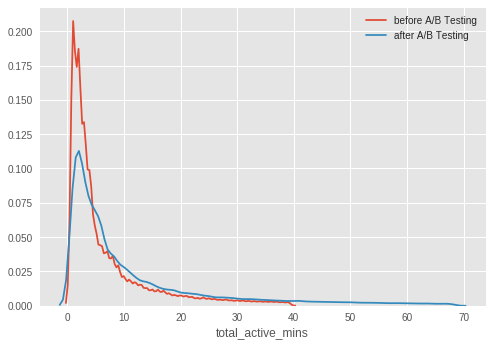

In [155]:
build_dist(before_AB_treatment_base_table_noout,after_AB_treatment_base_table_noout,
           "active_mins","active_mins","total_active_mins")

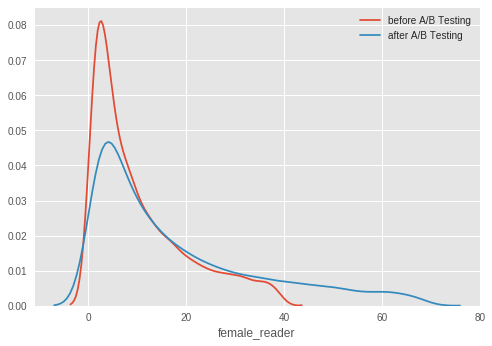

In [156]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","female_reader")


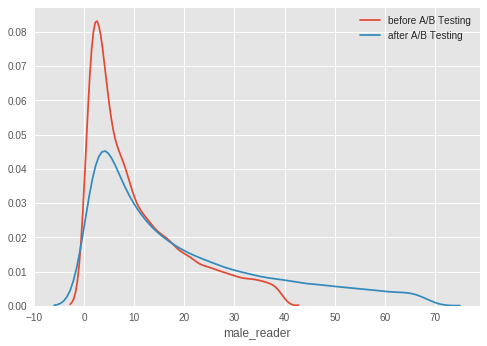

In [157]:


build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","male_reader")


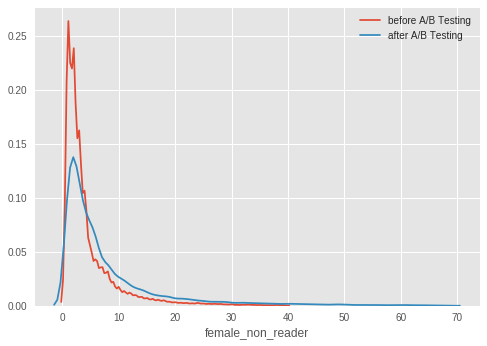

In [158]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins","female_non_reader")


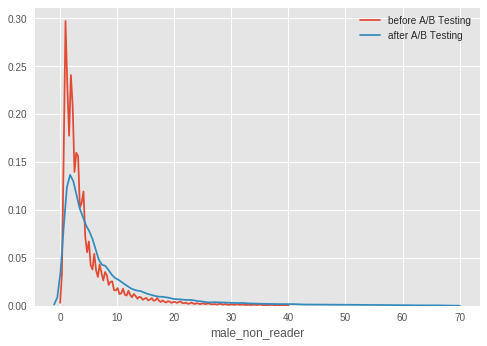

In [159]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins", "male_non_reader")


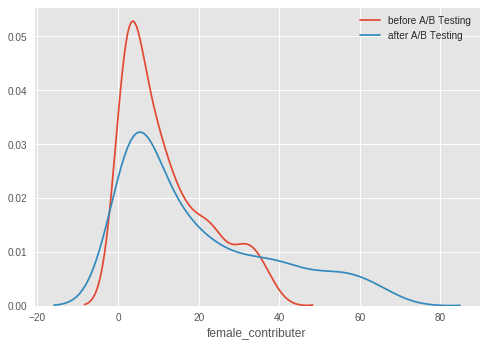

In [160]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "unknown")&(before_AB_treatment_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "unknown")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","female_contributer")

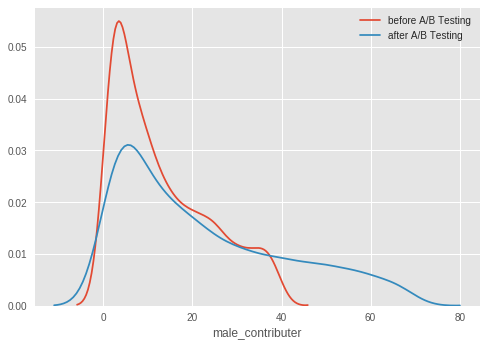

In [161]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","male_contributer")


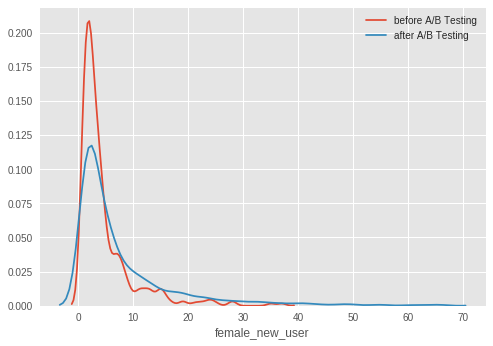

In [162]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","female_new_user")

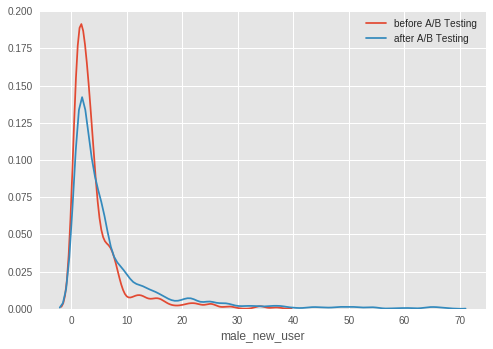

In [163]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","male_new_user")

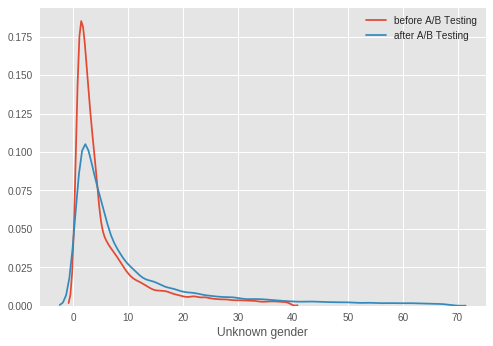

In [164]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "unknown")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "unknown")],
           "active_mins","active_mins","Unknown gender")

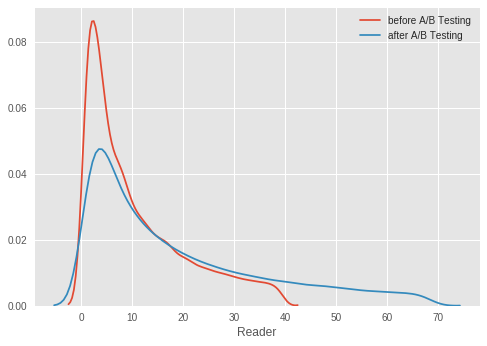

In [166]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "reader"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "reader"],
           "active_mins","active_mins","Reader")

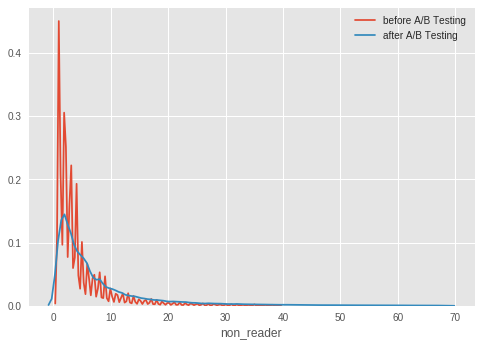

In [167]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "non_reader"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "non_reader"],
           "active_mins","active_mins","non_reader")

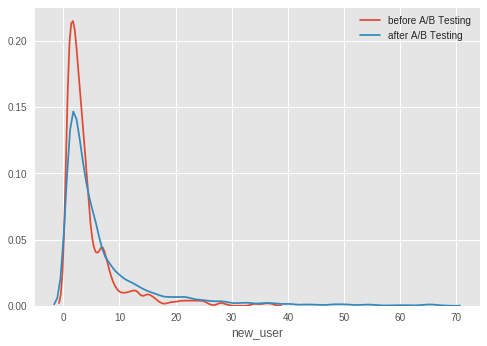

In [168]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "new_user"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "new_user"],
           "active_mins","active_mins","new_user")

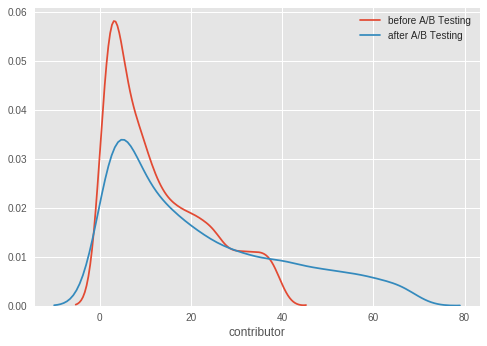

In [169]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "contributor"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "contributor"],
           "active_mins","active_mins","contributor")

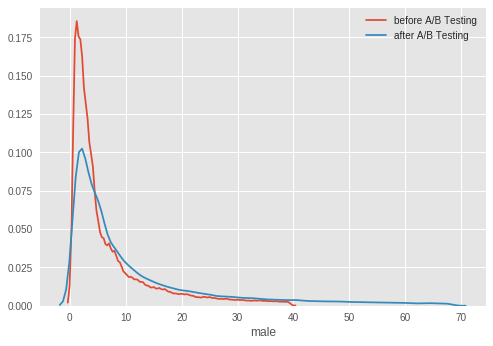

In [170]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "male"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "male"],
           "active_mins","active_mins","male")

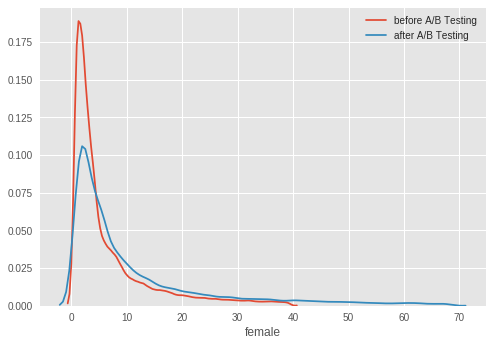

In [171]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "female"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "female"],
           "active_mins","active_mins","female")

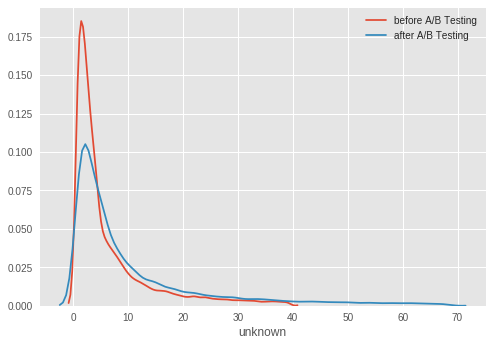

In [172]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "unknown"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "unknown"],
           "active_mins","active_mins","unknown")